In [1]:
!pip install striprtf;

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from striprtf.striprtf import rtf_to_text
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import re 
from sklearn.feature_extraction.text import CountVectorizer
import warnings

nltk.download('wordnet')
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True) 

[nltk_data] Downloading package wordnet to /Users/chetan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# **Data and Auxiliary Data Loading**

In [3]:
df = pd.read_csv("final_dataset.csv")
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5582,spam,This is the 2nd time we have tried 2 contact u...
5583,ham,Will ü b going to esplanade fr home?
5584,ham,"Pity, * was in mood for that. So...any other s..."
5585,ham,The guy did some bitching but I acted like i'd...


In [4]:
#For sms dataset
df = df.rename(columns={"Message":"content","Category":"category"})
df.category = (df.category == 'spam').astype("int")
df


,category,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5582,1,This is the 2nd time we have tried 2 contact u...
5583,0,Will ü b going to esplanade fr home?
5584,0,"Pity, * was in mood for that. So...any other s..."
5585,0,The guy did some bitching but I acted like i'd...


### **Downloading Stopwords and Contractions**

In [5]:
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chetan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
contractions_df = pd.read_csv('english_contractions.csv')
contractions_list = contractions_df.Contraction.values

#converting all the contractions to lower case
contractions_list = list(map(lambda word:word.lower(),contractions_list))
contractions_df

,Contraction,Meaning
0,'aight,alright
1,ain't,is not
2,amn't,am not
3,aren't,are not
4,can't,cannot
...,...,...
143,y'all're,you all are
144,you'd,you would
145,you'll,you will
146,you're,you are


In [7]:
print('Number of Spam Mails: ', (df.category==1).sum())
print('Number of Ham Mails: ',(df.category==0).sum())

Number of Spam Mails:  774
Number of Ham Mails:  4813


# **Feature Extraction**

In [8]:
def get_num_of_occurences(df,word_list):
    frequency_spam = {k:0 for k in word_list}#used to get the most frequently used contractions
    frequency_ham  = {k:0 for k in word_list}

    def get_number_of_words(content,words_list,category):

        content_split = content.lower().split()
        n_words = 0
        for word in content_split:
            if word in words_list:
                n_words +=1
                if category ==1:
                    frequency_spam[word]+=1
                if category ==0:
                    frequency_ham[word]+=1

        return n_words

    number_of_occurences  = np.zeros(len(df),dtype = np.int8)

    for i in range(len(df)):
        content = df.iloc[i].content    
        number_of_occurences[i] = get_number_of_words(content,word_list,df.iloc[i].content)

    return number_of_occurences,frequency_spam,frequency_ham

def print_most_common(freq):
    freq = sorted(freq.items(),key = lambda x: x[1],reverse=True)

    for i in range(len(freq)):
        word = freq[i][0]
        f = freq[i][1]

        if i>10 or f==0:
            break
        else:
            print("{:7} : {}".format(word,f))
            

In [9]:
def to_lower(sentence):
    return sentence.lower()

#f in the function name denotes indicates that it is a function
def remove_stopwords_f(sentence):
    sentence_split = sentence.lower().split()
    new_sentence = []
    for word in sentence_split:
        if word not in stopwords_list:
            new_sentence.append(word)
    return " ".join(new_sentence)

def remove_contractions_f(sentence):
    sentence_split = sentence.lower().split()
    new_sentence = []
    for word in sentence_split:
        if word not in contractions_list:
            new_sentence.append(word)
    return " ".join(new_sentence)

def remove_numbers_f(sentence):
    return re.sub('[0-9]+','',sentence)

def remove_special_char_f(sentence):
    return re.sub('[^a-zA-Z0-9\s]','',sentence)

In [10]:
def get_word_list_and_count(df,ngram = 1,category=1,max_number=10,
                            remove_stopwords=False,remove_numbers=False,remove_contractions=False):
    
    cv = CountVectorizer(max_features=max_number,ngram_range=(ngram,ngram))

    #getting the required content in the required form
    content_series = df[df.category==category].content
    if remove_stopwords:
        content_series = content_series.apply(remove_stopwords_f)

    if remove_contractions:
        content_series = content_series.apply(remove_contractions_f)

    if remove_numbers:
        content_series = content_series.apply(remove_numbers_f)

    content_vectorised = cv.fit_transform(content_series).toarray()
    word_list = cv.get_feature_names()
    word_count = content_vectorised.sum(axis=0)
    word_count_dict = dict(zip(word_list,word_count))
    
    return pd.Series(word_count_dict).sort_values(ascending =False)

### **Number of Stopwords and Contractions**

In [11]:
def add_contractions_stopwords_stat(df):
    df = df.copy()
    
    number_of_contractions_data = get_num_of_occurences(df,contractions_list)
    number_of_stopwords_data = get_num_of_occurences(df,stopwords_list)

    df['number_of_contractions'] = number_of_contractions_data[0]
    df['number_of_stopwords'] = number_of_stopwords_data[0]
    cache = {"contractions":number_of_contractions_data,"stopwords":number_of_stopwords_data}
    return df

### **Number of Numerical and Special Characters**

In [12]:
def add_specialchar_numericalchar_stat(df):
    df = df.copy()
    number_of_special_char  = np.zeros(len(df),dtype = np.int8)
    number_of_numerical_char  = np.zeros(len(df),dtype = np.int8)

    for i in range(len(df)):
        content = df.iloc[i].content
        number_of_special_char[i] = len(re.findall(r"[^a-zA-Z0-9\s',.]+",content))
        number_of_numerical_char[i] = len(re.findall(r'[0-9]+',content))

    df['number_of_special_characters'] = number_of_special_char
    df['number_of_numerical_characters'] = number_of_numerical_char

    return df

In [13]:
df = add_contractions_stopwords_stat(df)
df = add_specialchar_numericalchar_stat(df)

In [14]:
df.groupby("category").mean()

,number_of_contractions,number_of_stopwords,number_of_special_characters,number_of_numerical_characters
category,,,,
0,0.312279,5.529192,1.023894,0.260544
1,0.072351,6.741602,3.208010,4.383721


### **N-Gram Analysis**

#### **Spam**

In [15]:
print('Commonly used words in Spam Emails:')
get_word_list_and_count(df,ngram=1,category=1,max_number=10,remove_stopwords=True,remove_numbers=False)

Commonly used words in Spam Emails:


call      356
free      228
txt       163
ur        144
mobile    127
text      125
stop      121
claim     115
now       106
reply     104
dtype: int64

In [16]:
print('Commonly used bigrams in Spam Emails:')
get_word_list_and_count(df,ngram=2,category=1,max_number=10,remove_stopwords=True,remove_numbers=False)

Commonly used bigrams in Spam Emails:


co uk               49
please call         46
po box              27
1000 cash           23
guaranteed call     23
prize guaranteed    22
national rate       20
send stop           20
await collection    19
selected receive    19
dtype: int64

In [17]:
print('Commonly used trigrams in Spam Emails:')
get_word_list_and_count(df,ngram=3,category=1,max_number=10,remove_stopwords=False,remove_numbers=False)

Commonly used trigrams in Spam Emails:


you have won             50
prize guaranteed call    21
1000 cash or             19
find out who             18
from land line           18
urgent your mobile       18
account statement for    16
to contact you           16
valid 12hrs only         16
suite342 2lands row      15
dtype: int64

####**Non-Spam** 

In [18]:
print('Commonly used words in Non-Spam Emails')
get_word_list_and_count(df,ngram=1,category=0,max_number=10,remove_stopwords=True ,remove_numbers=False)

Commonly used words in Non-Spam Emails


gt      317
lt      315
get     304
ok      287
go      252
ll      248
ur      247
know    237
call    236
good    234
dtype: int64

In [19]:
print('Commonly used bigrams in Non-Spam Emails')
get_word_list_and_count(df,ngram=2,category=0,max_number=10,remove_stopwords=False,remove_numbers=False)

Commonly used bigrams in Non-Spam Emails


lt gt       275
are you     177
you are      94
do you       93
if you       92
in the       86
want to      83
going to     77
have to      70
to be        65
dtype: int64

In [20]:
print('Commonly used trigrams in Non-Spam Emails')
get_word_list_and_count(df,ngram=3,category=0,max_number=10,remove_stopwords=False,remove_numbers=False)

Commonly used trigrams in Non-Spam Emails


ll call later     39
sorry ll call     38
how are you       37
let me know       26
lt decimal gt     23
where are you     23
hope you are      21
when you re       20
happy new year    18
what are you      17
dtype: int64

# **Data Preprocessing**

In [21]:
print('Column                 Number of Null Entries')
print()
df.isnull().sum() #Ensuring that there are no empty entries

Column                 Number of Null Entries



category                          0
content                           0
number_of_contractions            0
number_of_stopwords               0
number_of_special_characters      0
number_of_numerical_characters    0
dtype: int64

In [22]:
def lemmatize(sentence):
    wnl = WordNetLemmatizer()
    sentence = sentence.split()
    sentence = [wnl.lemmatize(word) for word in sentence]
    sentence =  " ".join(sentence)
    return sentence

def process_sentence_with_conditions(sentence,remove_stopwords=True,remove_contractions=True,
                     remove_numbers = True,remove_special_char=True,lemmatize_sentence = True):
    sentence = sentence.lower()

    #these functions were defined earlier
    if remove_stopwords:
        sentence = remove_stopwords_f(sentence) 

    if remove_contractions:
        sentence = remove_contractions_f(sentence)

    if remove_numbers:
        sentence = remove_numbers_f(sentence)
        
    if remove_special_char:
        sentence = remove_special_char_f(sentence)
    
    if lemmatize_sentence:
        sentence = lemmatize(sentence)

    return sentence

def process_sentence(sentence):
    return process_sentence_with_conditions(sentence,True,True,True,True,True) #The conditions can be changed here

Creating a Copy of df

In [23]:
df_c = df.copy()
df_c.content = df_c.content.apply(process_sentence)  

In [24]:
features = ['content', 'number_of_special_characters',
       'number_of_numerical_characters', 'number_of_contractions',
       'number_of_stopwords']

df_X_train,df_X_test,y_train,y_test = train_test_split(df_c[features],df_c.category,test_size=0.25)

In [25]:
m=1000 #Hyperparameter 1, number of words/features

vectoriser = TfidfVectorizer(max_features=m)
vectoriser.fit(df_X_train.content);

In [26]:
def get_X(df_X,vectoriser,n_contractions=False,
                         n_stopwords=False,n_numbers=False,n_special_char=False):
    
    X = vectoriser.transform(df_X.content).toarray()


    if n_contractions == True:
        num_contractions_array_train = np.reshape(df_X.number_of_contractions.values,(-1,1))
        X = np.hstack((X,num_contractions_array_train))

    if n_stopwords == True:
        num_stopwords_array_train = np.reshape(df_X.number_of_stopwords.values,(-1,1))
        X = np.hstack((X,num_stopwords_array_train))

    if n_special_char == True:
        num_special_array_train = np.reshape(df_X.number_of_special_characters.values,(-1,1))
        X = np.hstack((X,num_special_array_train))
        
    if n_numbers == True:
        num_numbers_array_train = np.reshape(df_X.number_of_numerical_characters.values,(-1,1))
        X = np.hstack((X,num_numbers_array_train))
       
    return X  

In [27]:
#It can be chosen to include or exclude the following features
include_number_of_contractions = False
include_number_of_stopwords = False
include_number_of_numericalchar = True
include_number_of_specialchar = True

In [28]:
X_train = get_X(df_X_train,vectoriser,
                include_number_of_contractions,include_number_of_stopwords,
                include_number_of_numericalchar,include_number_of_specialchar)

X_test = get_X(df_X_test,vectoriser,
                include_number_of_contractions,include_number_of_stopwords,
                include_number_of_numericalchar,include_number_of_specialchar)

y_train,y_test = np.array(y_train),np.array(y_test)

In [29]:
print(X_train.shape)
print(X_test.shape)

(4190, 1002)
(1397, 1002)


### **PCA**

In [30]:
def display_principleComponents(X,num_components=2):
    #shape of X is (n,d)
    n = len(X)

    X_centered = X - X.mean(axis=0).reshape(1,-1)
    C = (X_centered.T)@X_centered/n
    w,V = np.linalg.eig(C)

    principalComponents = X@V[:,:num_components]

    plt.title('PCA on Training Data')
    sc1 = plt.scatter(principalComponents[:,0],principalComponents[:,1],c=y_train,s=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(*sc1.legend_elements())
    plt.show()

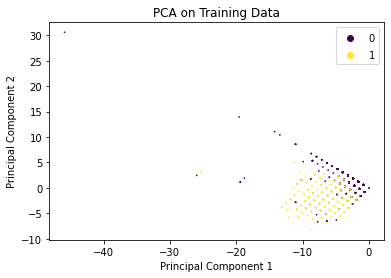

In [31]:
display_principleComponents(X_train, num_components=2)

# **Model Building**

In [32]:
def accuracy_score(y_true,y_preds):
    return (y_true==y_preds).sum()/len(y_true)

def access_model(clf,X,y):
    y_preds = clf.predict(X)
    print("Accuracy: %.4f"%accuracy_score(y,y_preds))
    print("\nConfusion Matrix")
    cm = confusion_matrix(y,y_preds)
    sns.heatmap(cm,cmap="Greens",annot=True,fmt='g')
    plt.xticks([])
    plt.yticks([])
    plt.show()

### **SVM**

In [33]:
from scipy.sparse import csr_matrix
import numpy as np

X_train_sparse = csr_matrix(X_train)
X_test_sparse = csr_matrix(X_test)

In [34]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


### **Hyperparameter Tuning**

In [35]:
parameters = {'kernel':['linear', 'rbf','poly'], 'C':[1,3,5],'gamma':['auto','scale']}

history = {'parameters':[],'accuracy_train':[],'accuracy_test':[],'model':[]}
for kernel in parameters['kernel']:
    for C in parameters['C']:
        for gamma in parameters['gamma']:
            clf = make_pipeline(StandardScaler(with_mean=False), svm.SVC(kernel = kernel,gamma=gamma,C=C))
            clf.fit(X_train_sparse, y_train)
            parameter_comb = {"kernel":kernel,"C":C,"gamma":gamma}

            accuracy_train = accuracy_score(y_train,clf.predict(X_train_sparse))
            accuracy_test = accuracy_score(y_test,clf.predict(X_test_sparse))

            
            history['parameters'].append(parameter_comb)
            history['accuracy_train'].append(accuracy_train)
            history['accuracy_test'].append(accuracy_test)
            history['model'].append(clf)

In [36]:
i = history['accuracy_test'].index(max(history['accuracy_test']))
best_model = history['model'][i]

In [37]:
print("Best Model Results")
print("Train Set Accuracy: ",history['accuracy_train'][i])
print("Test Set Accuracy:", history['accuracy_test'][i])
print(history['parameters'][i])

Best Model Results
Train Set Accuracy:  0.9988066825775657
Test Set Accuracy: 0.9749463135289907
{'kernel': 'rbf', 'C': 3, 'gamma': 'auto'}


Train Data
Accuracy: 0.9988

Confusion Matrix


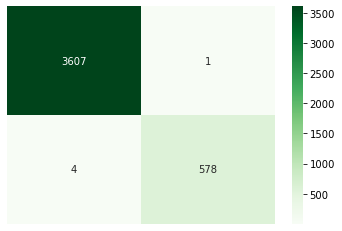

**********
Test Data
Accuracy: 0.9749

Confusion Matrix


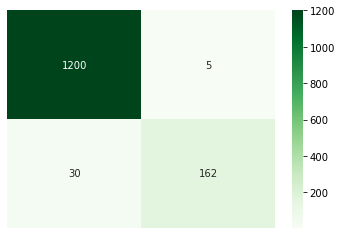

In [38]:
print("Train Data")
access_model(best_model,X_train,y_train)

print("**********")
print('Test Data')
access_model(best_model,X_test,y_test)

# **Testing on the Test Emails**

In [39]:
def get_number_of_words(content,words_list):

    content_split = content.lower().split()
    n_words = 0
    for word in content_split:
        if word in words_list:
            n_words +=1
    return n_words

def get_sentence_to_features_vector(sentence):

    n_of_contractions = get_number_of_words(sentence,contractions_list)
    n_of_stopwords = get_number_of_words(sentence,stopwords_list)
    n_of_special_char = len(re.findall(r"[^a-zA-Z0-9\s',.]+",sentence))
    n_of_numerical_char = len(re.findall(r'[0-9]+',sentence))
    
    processed_sentence = process_sentence(sentence)
    features_vector = vectoriser.transform([sentence]).toarray()

    if include_number_of_contractions:
        features_vector =  np.hstack((features_vector,np.array([[n_of_contractions]])))
        
    if include_number_of_stopwords:
        features_vector = np.hstack((features_vector,np.array([[n_of_stopwords]])))

    if include_number_of_specialchar:
        features_vector = np.hstack((features_vector,np.array([[n_of_special_char]])))

    if include_number_of_numericalchar:
        features_vector = np.hstack((features_vector,np.array([[n_of_numerical_char]])))
    return features_vector

#for testing an unseen dataframe with new mails 
def get_X_unseen(df_unseen):
    X_unseen = []
    for mail in df_unseen.content:
        X_unseen.append(get_sentence_to_features_vector(mail))
    
    return np.squeeze(np.array(X_unseen))

def test_input(model):
    x0_vector = get_sentence_to_features_vector(input('Enter the Mail Content: '))
    prediction = model.predict(x0_vector)
    print('The Mail is',(1-prediction[0])*'NOT a spam mail'+prediction[0]*'a spam mail')

### **Given Mails**

In [40]:
for i in [1,2]:
    filename = "test/email{}.txt".format(i)
    f = open(filename,'r')
    content = f.read()
    content = rtf_to_text(content)
    print(filename)
    print(content)
    print("****************")
    f.close()

test/email1.txt
Dear Sir,

PRML quiz was the first exam we have taken among all the other courses here at IIT Madras. We were not really sure about what kind of questions to expect either.

I have received a lot of requests from my classmates to request you to increase the number of quizzes to 6 and make it best 4 out of 6. I have raised this issue in the CR meeting and they have told me to ask you.

We would be really grateful if you could consider it.

Thanks and regards

****************
test/email2.txt
Dear Beneficiary,

The United Nations Compensation Commission (UNCC) has approved to pay you a compensation amount of US$1,500,000 (One Million, Five Hundred Thousand United State Dollars) due to losses and damages suffered as to delayed foreign contract payment of individuals, firms, contractors, inheritance, next-of-kin, super hurricane Sandy and lottery beneficiaries that originated from Africa, Europe, Americas, Asia including the Middle East. Your approved Compensation package h

### **Custom Prepared Dataset**

In [41]:
custom_df = pd.read_csv("custom_test_data.csv")
custom_df

,category,content
0,0,"Hello Tushar,\nI had a couple of doubts about ..."
1,0,"Sure Ma'am, that should be fine. A small corre..."
2,0,"Respected sir,\nI had a few doubts about assig..."
3,0,"Dear student,\n\n \n\nThank you for your email..."
4,0,"Respected sir,\nI am a student that stayed in ..."
5,0,"Hi Tushar,\nI am , a student of the CS5691: Pa..."
6,0,"Hello ,\nI am not having problem set/materials..."
7,0,"Dear ,\n\nThank you for your interest in this ..."
8,0,"Respected Sir,\nI am a 3rd-year engineering st..."
9,0,I am Bikash Gupta ME design student. We both ...


In [42]:
X_unseen = get_X_unseen(custom_df)

In [43]:
y_preds_unseen = (clf.predict(X_unseen))
y_preds_unseen

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1])

In [44]:
accuracy_score(custom_df.category,y_preds_unseen)

0.9473684210526315

### **Run this section to read the emails in test folder**
For it to work, the trained model should be available, run all the cells above to run this cell

In [45]:
import os
def get_predictions(model):
    email_names = os.listdir('./test')
    predictions = []
    for filename in email_names:
        if "email" in filename:
            f = open("test/"+filename,'r')
            content = f.read()
            content = rtf_to_text(content)
            f.close()   
            x0_vector = get_sentence_to_features_vector(content)
            prediction = model.predict(x0_vector).item()
            predictions.append(prediction)
        else:
            print("Invalid File Name: ",filename)
    return predictions

In [46]:
get_predictions(best_model)

Invalid File Name:  .DS_Store


[0, 0]